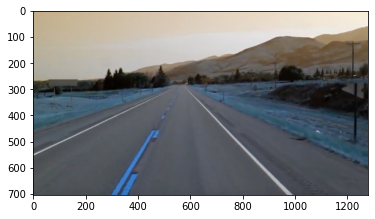

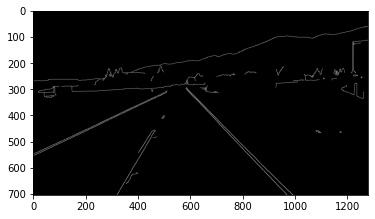

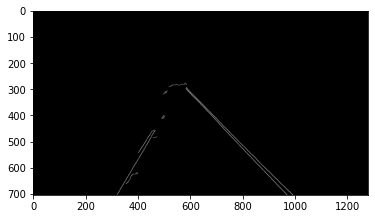

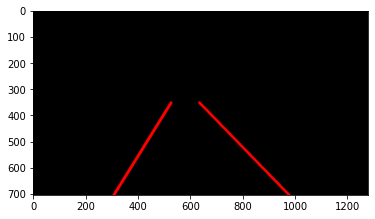

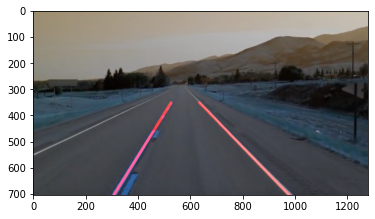

In [50]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

image = cv2.imread('./../../data/self_driving_car/road_image/test_image.jpg')
plt.imshow(image)
plt.show()

lane_image = np.copy(image)

def canny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) # Make it a grayscale image
    blur = cv2.GaussianBlur(gray, (5, 5), 0)       # Add gaussian blur - look into this more as to why
    return cv2.Canny(blur, 50, 150)                # Find gradient changes and show only where there are large changes in colour

def region_of_interest(image):
    height = image.shape[0]
    polygons = np.array([
        [(200, height), (1100, height), (550, 250)]
    ]) #Creates shape wanted to be outlined in image
    mask = np.zeros_like(image) #Makes np array same size as image
    cv2.fillPoly(mask, polygons, 255)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image
    
def display_lines(image, lines):
    line_image = np.zeros_like(image)
    
    if lines is not None:
        for x1, y1, x2, y2 in lines:
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10)
            
    return line_image

def get_image_lines(image):
    return cv2.HoughLinesP(
        image, 
        2,                # 2 pixels
        np.pi/180,        # 1 degree of precision, 1 degree, or pi / 180
        100,              # Threshold: min number of votes in a bin to be assumed a line, depends on model
        np.array([]),     # Placeholder array
        minLineLength=40, # Length of a line in pixels we will accept in the output
        maxLineGap=5      # Max distance in pixels we will allow lines to be considered a single
    )

def make_coordinates(image, line_parameters):
    slope, intercept = line_parameters
    y1 = int(image.shape[0])
    y2 = int(y1 * (3/6))
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    return np.array([x1, y1, x2, y2])

def average_slope_intercept(image, lines):
    left_fit = []
    right_fit = []
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1, y2), 1) # Last argument is to return a polynomial of degree 1
        slope = parameters[0]
        intercept = parameters[1]
        if slope < 0:
            left_fit.append((slope, intercept))
        else:
            right_fit.append((slope, intercept))
    
    left_fit_average = np.average(left_fit, axis=0)
    right_fit_average = np.average(right_fit, axis=0)
    left_line = make_coordinates(image, left_fit_average)
    right_line = make_coordinates(image, right_fit_average)
    return np.array([left_line, right_line])
    
canny_image = canny(lane_image)
plt.imshow(canny_image, cmap="gray")
plt.show()

cropped_image = region_of_interest(canny_image)
plt.imshow(cropped_image, cmap="gray")
plt.show()

lines = get_image_lines(cropped_image)
averaged_lines = average_slope_intercept(lane_image, lines)
line_image = display_lines(lane_image, averaged_lines)
plt.imshow(line_image, cmap="gray")
plt.show()

# Image followed by the weight, multiplies all elements in array by 0.8, reducing image intensity
# Final argument is the gamma argument, adds to the sum
combo_image = cv2.addWeighted(lane_image, 0.8, line_image, 1, 1)
plt.imshow(combo_image)
plt.show()

In [ ]:
video = cv2.VideoCapture('./../../data/self_driving_car/road_video/lanes_video.mp4')

while(cap.isOpened()):
    _, frame = cap.read()
    
    canny_image = canny(frame)
    cropped_image = region_of_interest(canny_image)
    averaged_lines = average_slope_intercept(frame, lines)
    line_image = display_lines(frame, averaged_lines)
    combo_image = cv2.addWeighted(frame, 0.8, line_image, 1, 1)
    plt.imshow(combo_image)
    plt.show()